In [22]:
# Appeding the path to the scaman package
import sys
sys.path.append('/Users/berke/Codes/scaman/scaman') 
# flann path
sys.path.append('/Users/berke/Codes/python/flann/src/python')
import numpy as np

In [23]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X = np.asarray(mnist.data)
y = np.asarray(mnist.target)

# Stratified sampling: 10% of the data
X, _, y, _ = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)



/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [24]:
#shape of the data
print(X.shape)
print(y.shape)



(7000, 784)
(7000,)


In [25]:
# Step 2: Center data matrix
import numpy as np
means = np.mean(X, axis=0)
X_centered = X - means
# Step 3: Verify that covariance matrix is centered
assert np.allclose(np.mean(X_centered, axis=0), np.zeros_like(means))


In [27]:
# Step 4: Compute covariance matrix
cov = np.cov(X, rowvar=False)
eigs = np.linalg.eig(cov)[0]
eigs_sorted = np.flip(np.sort(eigs))
variances = np.cumsum(eigs_sorted)/np.sum(eigs_sorted)
tv = 0.8
actual_dim = np.argmax(np.array(variances)>tv)
print(eigs_sorted)

[ 3.34614185e+05+0.00000000e+00j  2.48478537e+05+0.00000000e+00j
  2.08074608e+05+0.00000000e+00j  1.87839024e+05+0.00000000e+00j
  1.73149915e+05+0.00000000e+00j  1.50731456e+05+0.00000000e+00j
  1.09294703e+05+0.00000000e+00j  1.00690864e+05+0.00000000e+00j
  9.31498625e+04+0.00000000e+00j  8.20213632e+04+0.00000000e+00j
  7.20666956e+04+0.00000000e+00j  6.89951555e+04+0.00000000e+00j
  5.94918954e+04+0.00000000e+00j  5.85587099e+04+0.00000000e+00j
  5.34582310e+04+0.00000000e+00j  5.05846242e+04+0.00000000e+00j
  4.53403422e+04+0.00000000e+00j  4.29515725e+04+0.00000000e+00j
  4.06277616e+04+0.00000000e+00j  4.02701137e+04+0.00000000e+00j
  3.65525615e+04+0.00000000e+00j  3.44532159e+04+0.00000000e+00j
  3.32378049e+04+0.00000000e+00j  3.17020963e+04+0.00000000e+00j
  3.01847311e+04+0.00000000e+00j  2.90708424e+04+0.00000000e+00j
  2.77030171e+04+0.00000000e+00j  2.71060419e+04+0.00000000e+00j
  2.50221379e+04+0.00000000e+00j  2.39177139e+04+0.00000000e+00j
  2.25214128e+04+0.000000

In [28]:
from serial.pca import PCA
from utils.intrinsic_dimension_estimator import Estimator

In [29]:
# Step 5: Create Estimator instance
estimator = Estimator(X_centered, p=10, nk=8, epsilon=0.1, delta=0.1, tv = tv)

estDim, estVar, estDimF = estimator.estimator()
print(f"Actual Dim = {actual_dim}, Estimated Dim = {estDim}, Estimated Var = {estVar}, Estimated Final Dim = {estDimF}")

Actual Dim = 42, Estimated Dim = 17, Estimated Var = 0.8179315117934605, Estimated Final Dim = 17


In [30]:
## Created test with estimated dimension and PCA
pca = PCA(n_components=estDim,eig_method='slepc')
embedding_pca = pca.fit_transform(X)
#embedding shape
print(embedding_pca.shape)
#embedding type
print(type(embedding_pca))
# convert complex matrix to real matrix
embedding_pca = np.real(embedding_pca)

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 17
Stopping condition: tol=0.001, maxit=100
Number of converged eigenpairs 19

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 334614.184989       9.75118e-16
 248478.537182       1.07225e-15
 208074.608165       1.21111e-15
 187839.024166       1.32932e-15
 173149.915185        1.1995e-15
 150731.456010        1.4949e-15
 109294.703052       8.56452e-14
 100690.864278       1.12841e-11
 93149.862471       2.57862e-11
 82021.363177       3.31773e-09
 72066.695557       1.38731e-06
 68995.155474       1.16321e-06
 59491.863819       0.000528813
 58558.709907       3.39453e-06
 53458.231247       2.22362e-05
 50584.625177       5.73744e-05
 45340.342327       3.34424e-05
 42951.573820       0.000115729
 40627.667285        0.00099492

Tim

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.2, random_state=42)

# Fit the KNN model on the training data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Use the trained model to predict the labels for the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of PCA applied data with estDim: {accuracy}")



Accuracy of PCA applied data with estDim: 0.9442857142857143


In [32]:
# Split the data into training and testing sets for original data
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the KNN model on the training data for original data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_org, y_train_org)

# Use the trained model to predict the labels for the testing data for original data
y_pred_org = knn.predict(X_test_org)

# Calculate the accuracy of the model for original data
accuracy_org = accuracy_score(y_test_org, y_pred_org)
print(f"Accuracy of original dataset: {accuracy_org}")

Accuracy of original dataset: 0.9364285714285714


In [33]:
# Initialize an empty list to store the accuracies
accuracies = []

# Define the range of dimensions
dimensions = range(2, 50, 2)

# Loop through each dimension
for dim in dimensions:
    # Perform PCA with the current dimension
    pca = PCA(n_components=dim,eig_method='slepc')
    embedding_pca = pca.fit_transform(X)
    embedding_pca = np.real(embedding_pca)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.2, random_state=42)
    
    # Fit the KNN model on the training data
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, y_train)
    
    # Use the trained model to predict the labels for the testing data
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

# Print the accuracies for each dimension
for dim, accuracy in zip(dimensions, accuracies):
    print(f"Dimension: {dim}, Accuracy: {accuracy}")

print(accuracies)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 2
Stopping condition: tol=0.001, maxit=100
Number of converged eigenpairs 6

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 334614.184989       5.20673e-12
 248478.537181       1.38372e-06
 208074.607826       3.32711e-05
 187839.022891       6.57685e-05
 173149.914137       6.01115e-05
 150731.433818       0.000274683

Time taken to compute eigenvalues: 0.0069 seconds
Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 4
Stopping condition: tol=0.001, maxit=100
Number of converged eigenpairs 6

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- --------------

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_98326/3456713424.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Accuracies')


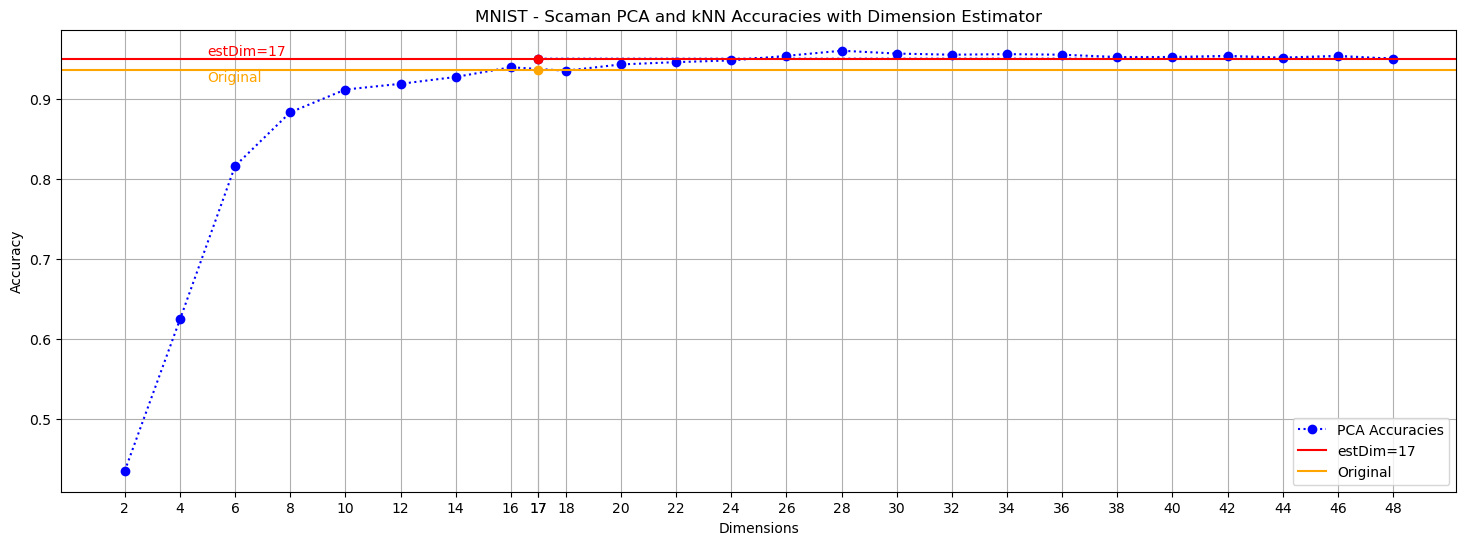

In [51]:
import matplotlib.pyplot as plt

# Create lists of dimensions and accuracies
dimensions = list(range(2, 50, 2))
#accuracies = [0.44285714285714284, 0.6171428571428571, 0.8119047619047619, 0.8766666666666667, 0.9052380952380953, 0.9176190476190477, 0.9266666666666666, 0.939047619047619, 0.9319047619047619, 0.9395238095238095, 0.9414285714285714, 0.9461904761904761, 0.9504761904761905, 0.9571428571428572, 0.9523809523809523, 0.9528571428571428, 0.9514285714285714, 0.9519047619047619, 0.9504761904761905, 0.949047619047619, 0.9485714285714286, 0.949047619047619, 0.9495238095238095, 0.9457142857142857]
#accuracies = [0.435, 0.6242857142857143, 0.8164285714285714, 0.8835714285714286, 0.9121428571428571, 0.9192857142857143, 0.9278571428571428, 0.94, 0.9357142857142857, 0.9435714285714286, 0.9464285714285714, 0.9485714285714286, 0.9542857142857143, 0.9607142857142857, 0.9571428571428572, 0.9557142857142857, 0.9564285714285714, 0.9557142857142857, 0.9528571428571428, 0.9528571428571428, 0.9542857142857143, 0.9521428571428572, 0.9542857142857143, 0.9507142857142857]

dimensions.append(estDim)
#accuracies.append(accuracy)

# Set the size of the plot
plt.figure(figsize=(18, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Accuracies')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim=17', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original')
plt.text(5, accuracy_org, 'Original', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
plt.title('MNIST - Scaman PCA and kNN Accuracies with Dimension Estimator')
plt.legend()

plt.show()
